# Notebook de modélisation

# Imports

In [1]:
#Auto chargement des imports option2
import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import seaborn as sns
sns.set(style="ticks") #white, dark, whitegrid, darkgrid, ticks
# directory reach
PROJECT_ROOT = os.path.dirname(os.path.abspath(''))
sys.path.append(PROJECT_ROOT)

In [3]:
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from src.utils import udf

In [5]:
data = pd.read_csv(Path(PROJECT_ROOT + '/data/data_pre_processed_final_v0.csv'), index_col=[0])
#data = pd.read_csv(Path(PROJECT_ROOT + '/data/data_pre_processed_final.csv'), index_col=[0])
data.set_index('SK_ID_CURR', inplace=True)
data.head()
#data/data_pre_processed_final_v0.csv

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,406597.5,24700.5,0.018800,-9461,-637.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,1293502.5,35698.5,0.003542,-16765,-1188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,135000.0,6750.0,0.010030,-19046,-225.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,312682.5,29686.5,0.008020,-19005,-3040.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100007,0.0,0,0,0,0,513000.0,21865.5,0.028660,-19932,-3038.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape

(356251, 375)

# Score métier

**La famille des F-beta scores**

Le F1-score appartient à la famille plus large des F-beta scores. Dans le cas du F1-score, les erreurs (FN+FP) faites par le modèle sont pondérées par un facteur 1⁄2. Le F1-score accorde ainsi la même importance à la precision et au recall, et donc aux faux positifs et aux faux négatifs.


Le F-beta score permet de varier la pondération de ces termes :

\begin{equation*}
\text{F}_\beta\text{-score} = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}
\end{equation*}

Ce qui s’écrit également :

\begin{equation*}
\text{F}_\beta \text{-score} = \frac{TP}{TP+\frac{1}{1+\beta^2}(\beta^2 FN+FP)}
\end{equation*}

Résumons :

- Pour $\beta \geq 1$, on accorde plus d’importance au recall (autrement dit aux faux négatifs).
- Pour $\beta \leq 1$, on accorde plus d’importance à la precision (autrement dit aux faux positifs).
- Pour $\beta = 1$, on retrouve le F1-score, qui accorde autant d’importance à la precision qu’au recall.

Choix d'une valeur de $\beta$ pour le score métier:

- Supposons que nous voulons donner 10 fois plus d'importance au recall qu'à la precision alors:

  $$\beta = \sqrt{10} \approx 3.1622776601683795 \Longrightarrow 2.4025FN + 0.2403FP$$

# Gestion du déséquibre de class

## Comparaison des méthodes

In [7]:
import imblearn
from imblearn import FunctionSampler
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, fbeta_score, ConfusionMatrixDisplay

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer

from sklearn.ensemble import RandomForestClassifier

print(imblearn.__version__)

0.9.1


In [8]:
import sklearn
sklearn.__version__

'1.1.1'

In [9]:
def remove_infite(df):
    return df[np.isfinite(df).all(1)]

In [ ]:
#Reduction des données pour tester les méthodes d'équilibrage
nb_class_1 = int(len(data[data.TARGET == 1])*10/100)
nb_class_0 = int(len(data[data.TARGET == 0])*10/100)
print(f"10% des la classe 0 : {nb_class_0}\n10% de la classe 1 : {nb_class_1}")

In [10]:
df = pd.concat([
        data[data.TARGET == 0].sample(nb_class_0), 
        data[data.TARGET == 1].sample(nb_class_1)
    ], ignore_index=True
)

In [11]:
df.TARGET.value_counts()

0.0    28268
1.0     2482
Name: TARGET, dtype: int64

In [12]:
# Separation des données
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (30750, 212), test shape: (0, 212)


In [13]:
#imputation
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)
train_df.isna().sum().sum()

/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


0

In [14]:
train_df = remove_infite(train_df)
test_df = remove_infite(test_df)

In [15]:
y = train_df['TARGET']
del train_df['TARGET']
del test_df['TARGET']

Le lebal positive minoritaire est la class : 1.0


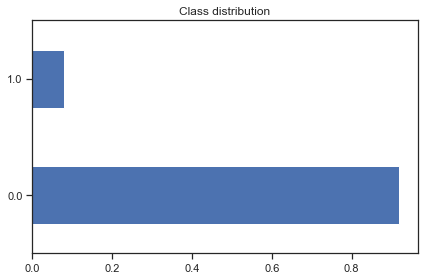

In [16]:
class_distribution = pd.Series(y).value_counts(normalize=True)
ax = class_distribution.plot.barh()
ax.set_title("Class distribution")
pos_label = class_distribution.idxmin()
plt.tight_layout()
print(f"Le lebal positive minoritaire est la class : {pos_label}")

In [17]:
classifier = RandomForestClassifier(random_state=42)

pipeline = [
    make_pipeline(FunctionSampler(), classifier),
    make_pipeline(RandomOverSampler(random_state=42), classifier),
    make_pipeline(ADASYN(random_state=42), classifier),
    make_pipeline(SMOTE(random_state=42), classifier),
    make_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced'))
]

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

In [19]:
X = train_df.values
y = y.values

In [20]:
disp = []
for model in tqdm(pipeline):
    # compute the mean fpr/tpr to get the mean ROC curve
    mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        
        model.fit(X[train], y[train])
        y_proba = model.predict_proba(X[test])

        pos_label_idx = np.flatnonzero(model.classes_ == pos_label)[0]
        fpr, tpr, thresholds = roc_curve(
            y[test], y_proba[:, pos_label_idx], pos_label=pos_label
        )
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Create a display that we will reuse to make the aggregated plots for
    # all methods
    disp.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr,
            roc_auc=mean_auc,
            estimator_name=f"{model[0].__class__.__name__}",
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

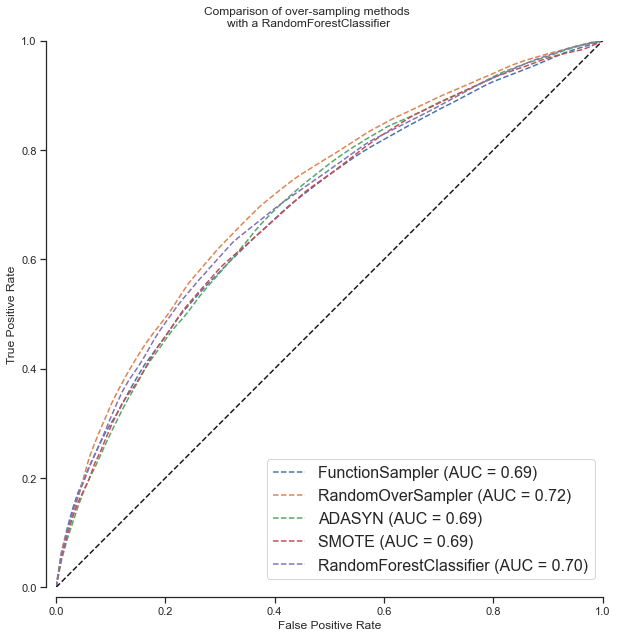

In [21]:
fig, ax = plt.subplots(figsize=(9, 9))
for d in disp:
    d.plot(ax=ax, linestyle="--")
ax.plot([0, 1], [0, 1], linestyle="--", color="k")
ax.axis("square")
fig.suptitle("Comparison of over-sampling methods \nwith a RandomForestClassifier")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(offset=10, ax=ax)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

- L'AUC n'étant pas la métrique la plus importante pour nous regardons le f3_score notre métrique métier

In [15]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [16]:
from sklearn.metrics import make_scorer
scoring = {'accuracy': make_scorer(accuracy_score),'f3_score': make_scorer(fbeta_score, beta=3)}

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

In [25]:
#Accuracy ROC AUC sans re-équilibrage
classifier = classifier = KNeighborsClassifier(n_neighbors=5)
scores = cross_validate(classifier, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
print('Mean f3_score: %.3f' % mean(scores['test_f3_score']))
print('Mean accuracy: %.3f' % mean(scores['test_accuracy']))

Mean f3_score: 0.011
Mean accuracy: 0.914


In [26]:
classifier = KNeighborsClassifier(n_neighbors=5)

pipeline = [
    make_pipeline(FunctionSampler(), classifier),
    make_pipeline(RandomOverSampler(random_state=42), classifier),
    make_pipeline(ADASYN(random_state=42), classifier),
    make_pipeline(SMOTE(random_state=42), classifier)
]

In [27]:
metric_values = {}
for model in tqdm(pipeline):
    
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    metric_values[f"{model[0].__class__.__name__}"] = {'test_f3_score': scores['test_f3_score'],
                                                      'test_accuracy': scores['test_accuracy']}
    
    print(f"{model[0].__class__.__name__}")
    print('Mean f3_score: %.3f' % mean(scores['test_f3_score']))
    print('Std f3_score: %.3f' % std(scores['test_f3_score']))
    print('Mean accuracy: %.3f' % mean(scores['test_accuracy']), "\n")

  0%|          | 0/4 [00:00<?, ?it/s]

FunctionSampler
Mean f3_score: 0.011
Std f3_score: 0.004
Mean accuracy: 0.914 

RandomOverSampler
Mean f3_score: 0.216
Std f3_score: 0.017
Mean accuracy: 0.738 

ADASYN
Mean f3_score: 0.282
Std f3_score: 0.012
Mean accuracy: 0.659 

SMOTE
Mean f3_score: 0.269
Std f3_score: 0.009
Mean accuracy: 0.665 



## Optimisation de SMOTE

In [28]:
#SMOTE optimization
k_values = range(1, 21)
test_f3_score_means = []
test_accuracy_means =[]

for k in tqdm(k_values):
    # define pipeline
    model = KNeighborsClassifier(n_neighbors=5)
    over = SMOTE(k_neighbors=k, random_state=1)
    
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    mean_f3_score = mean(scores['test_f3_score'])
    mean_accuracy = mean(scores['test_accuracy'])
    
    test_f3_score_means.append(mean_f3_score)
    test_accuracy_means.append(mean_accuracy)
        
    print('> k=%d, Mean acccuracy: %.3f, Mean f3_score: %3f' % (k, mean_accuracy, mean_f3_score))

  0%|          | 0/20 [00:00<?, ?it/s]

> k=1, Mean acccuracy: 0.709, Mean f3_score: 0.241712
> k=2, Mean acccuracy: 0.688, Mean f3_score: 0.257604
> k=3, Mean acccuracy: 0.676, Mean f3_score: 0.262488
> k=4, Mean acccuracy: 0.669, Mean f3_score: 0.264810
> k=5, Mean acccuracy: 0.666, Mean f3_score: 0.272404
> k=6, Mean acccuracy: 0.660, Mean f3_score: 0.270603
> k=7, Mean acccuracy: 0.657, Mean f3_score: 0.276019
> k=8, Mean acccuracy: 0.655, Mean f3_score: 0.282885
> k=9, Mean acccuracy: 0.652, Mean f3_score: 0.282345
> k=10, Mean acccuracy: 0.650, Mean f3_score: 0.286847
> k=11, Mean acccuracy: 0.649, Mean f3_score: 0.289894
> k=12, Mean acccuracy: 0.647, Mean f3_score: 0.287630
> k=13, Mean acccuracy: 0.644, Mean f3_score: 0.289089
> k=14, Mean acccuracy: 0.642, Mean f3_score: 0.292204
> k=15, Mean acccuracy: 0.641, Mean f3_score: 0.291916
> k=16, Mean acccuracy: 0.639, Mean f3_score: 0.289708
> k=17, Mean acccuracy: 0.637, Mean f3_score: 0.294162
> k=18, Mean acccuracy: 0.637, Mean f3_score: 0.294469
> k=19, Mean acccur

In [29]:
df = pd.DataFrame([k_values, test_accuracy_means, test_f3_score_means]).T
df = df.rename(columns={0:'k_values', 1:'mean_accuracy', 2:'mean_f3_score'})
df.set_index('k_values', inplace=True)
df.head()

,mean_accuracy,mean_f3_score
k_values,,
1.0,0.709041,0.241712
2.0,0.687566,0.257604
3.0,0.675902,0.262488
4.0,0.668954,0.264810
5.0,0.665507,0.272404


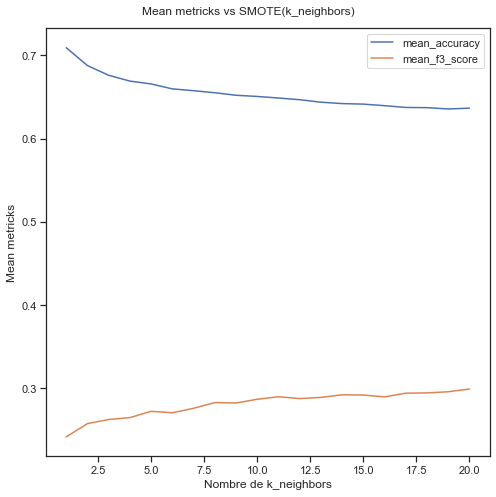

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))

#plt.plot(k_values, Scores) #.plot(ax=ax, linestyle="--")
df.plot(ax=ax)
ax.set_xlabel("Nombre de k_neighbors")
ax.set_ylabel("Mean metricks")
fig.suptitle("Mean metricks vs SMOTE(k_neighbors)")
plt.tight_layout()
plt.show()

-  $k_neighbors = 17$ semble convenir pour le moment

# Modélisation

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.pipeline import Pipeline

import mlflow
import mlflow.sklearn

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=False)

In [12]:
mlflow.set_tracking_uri("file://" + PROJECT_ROOT + "/mlruns")

## Preparation des données

In [18]:
#Reduction des données pour optimiser les modèles et les comparer.
nb_class_1 = int(len(data[data.TARGET == 1])*10/100)
nb_class_0 = int(len(data[data.TARGET == 0])*10/100)
print(f"10% de la classe 0 : {nb_class_0}\n10% de la classe 1 : {nb_class_1}\n")

df = pd.concat([
         data[data.TARGET == 0].sample(nb_class_0, random_state=42), 
         data[data.TARGET == 1].sample(nb_class_1, random_state=42),
    ], ignore_index=True
)

# Separation des données
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

#imputation
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)
train_df.isna().sum().sum()

train_df = remove_infite(train_df)
test_df = remove_infite(test_df)

#Feature à normaliser
var_to_norm = []
for var in train_df.columns:
    
    if len(train_df[var].value_counts().values.tolist()) > 2:
        var_to_norm.append(var)
        
scaler = StandardScaler()
train_df[var_to_norm] = scaler.fit_transform(train_df[var_to_norm])
print("Nombre de variables normalisés : {}".format(len(var_to_norm)))

y = train_df['TARGET']
del train_df['TARGET']
del test_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(train_df, y, stratify=y, random_state=42)
print(f"Train Dimension: \nX_train : {X_train.shape} \nX_test : {X_test.shape} \ny_train : {y_train.shape} \ny_test : {y_test.shape}")

X = train_df.values
y = y.values

10% de la classe 0 : 28268
10% de la classe 1 : 2482

Train shape: (30750, 375), test shape: (0, 375)
Nombre de variables normalisés : 251
Train Dimension: 
X_train : (23062, 374) 
X_test : (7688, 374) 
y_train : (23062,) 
y_test : (7688,)


In [39]:
smote = SMOTE(random_state=1001, k_neighbors=17)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [20]:
#y_train_resampled.value_counts()

In [21]:
y_train.value_counts()

0.0    21201
1.0     1861
Name: TARGET, dtype: int64

In [22]:
y_test.value_counts()

0.0    7067
1.0     621
Name: TARGET, dtype: int64

In [34]:
proba_values = []
def custom_metric(y_true, y_pred_proba, proba_values=proba_values, return_proba=False, in_model=False):
    """Cherche le seuil de probabilité qui minimise le score métier - 10FN + FP
    et calcule le f3_score avec les labels prédits et return ce score"""
    
    count = 0
    for threshold in np.arange(0.2, 0.9, 0.15):
        label_pred_threshold = np.where(y_pred_proba >= threshold, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_true, label_pred_threshold).ravel()
        f3_score = fbeta_score(y_true, label_pred_threshold, beta=sqrt(10))
        acc = accuracy_score(y_true, label_pred_threshold)
        #score = mean([acc, f3_score])
        
        if count >= 10*fn + fp - f3_score or count == 0:
            count = 10*fn + fp - f3_score
            
            threshold_f3 = threshold
            proba_values.append(threshold)
            #print(count)
        #else:
            #print("not valid", count, threshold, threshold_f3)
    label_pred_threshold = np.where(y_pred_proba >= threshold_f3, 1, 0)
    f3_score = fbeta_score(y_true, label_pred_threshold, beta=sqrt(10))
    acc = accuracy_score(y_true, label_pred_threshold)
    score = mean([acc, f3_score])
    if not in_model:
        print(f"\nPour le seuil {np.round(threshold_f3, 3)}, le f3_score est : {np.round(f3_score, 3)} et le mean score est : {np.round(score, 3)}")
    
    if return_proba:
        return score, threshold_f3
    else:
        return f3_score

In [35]:
def custom_score(y_true, y_pred_proba):
    
    #y_pred_proba = estimator.predict_proba(X)
    score = custom_metric(y_true, y_pred_proba, in_model=True)
    return score

proba_values = []
custom_score = make_scorer(custom_score, needs_proba=True)                                 

In [31]:
X_train, X_test, y_train, y_test, feature_names = udf.data_reader(data, 100,)# save_test_df=True)

100% de la classe 0 : 282682
100% de la classe 1 : 24825

Train shape: (307507, 375), test shape: (48744, 375)
Nombre de variables normalisés : 251
Train Dimension: 
X_train : (230629, 374) 
X_test : (76877, 374) 
y_train : (230629,) 
y_test : (76877,)


In [21]:
test_df = pd.read_csv("/Users/kone/Desktop/Oc_Formation/Projets/Projet7/openclassrooms_projects7/model_and_data/test_df.csv", index_col=[0])
test_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,0,0,-0.577530,-0.075102,-0.451695,-0.146668,-0.734183,-0.161753,-0.052189,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100005,0,0,0,-0.577530,-0.934825,-0.671813,1.079459,-0.464475,-1.089349,-1.173430,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100013,0,1,0,-0.577530,0.159595,2.943833,-0.127871,-0.916815,-1.084148,0.797684,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100028,1,0,0,2.192118,2.424820,1.511669,0.399884,0.472288,0.038503,0.847643,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100038,0,1,1,0.807294,0.065770,0.342157,-0.783588,0.686772,-0.102803,0.279926,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0


In [22]:
row = test_df[test_df.index == 100001]
row

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,0,0,-0.57753,-0.075102,-0.451695,-0.146668,-0.734183,-0.161753,-0.052189,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0


In [29]:
predic_proba = [1] #model.predict_proba(row)[:,1]
predic_proba

[1]

In [30]:
result = permutation_importance(
            model, row, predic_proba,n_repeats=5, random_state=42, n_jobs=-1
        )

KeyboardInterrupt: 

## Base-line

### Conscturction

In [19]:
import pickle as p
model_path = "/Users/kone/Desktop/Oc_Formation/Projets/Projet7/openclassrooms_projects7/model_and_data/model.pkl"

model = p.load(open(model_path, 'rb'))
model

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x7F9DB5308E40, shuffle=False),
                                    estimators=[('LogisticRegression',
                                                 LogisticRegression(C=6.681553108313681e-08,
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    tol=0.0002329433780056682))],
                                    final_estimator=RandomForestClassifier(max_depth=20,
                                                                           min_samples_leaf=10,
                                                                           min_samples_split=6,
                                                                           n_estimators=882),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='predict_proba'))])

In [24]:
y_pred_proba = model.predict_proba(X_test)[:,1]

In [26]:
threshold_f3 = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.2, le f3_score est : 0.532 et le mean score est : 0.587


Accuracy score : 0.641349
f3_score : 0.532339 

Mean evalation score : 0.586844


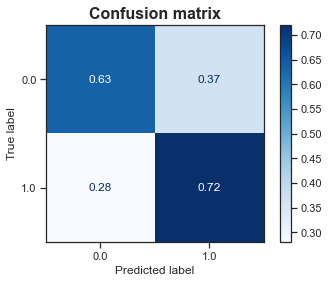

In [27]:
evaluate_model(model, X_test, y_test, threshold_f3)

In [110]:
from sklearn.dummy import DummyClassifier

In [97]:
#Construction d'un modèle base-line avec avec la strategie uniforme
dummy_classifier = DummyClassifier(strategy='uniform', random_state=42)
dummy_smote = Pipeline([('smote', smote), ('model', dummy_classifier)])
dummy_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 DummyClassifier(random_state=42, strategy='uniform'))])

In [111]:
y_pred_proba = dummy_classifier.predict_proba(X_test)[:,1]

In [112]:
threshold_f3 = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.8, le f3_score est : 0.0 et le mean score est : 0.46


Accuracy score : 0.724339
f3_score : 0.709340 

Mean evalation score : 0.716840


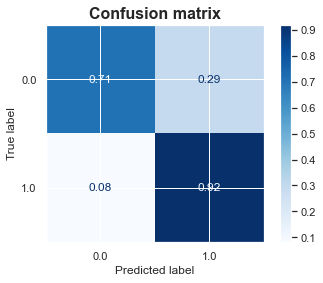

In [46]:
evaluate_model(model, X_test, y_test, threshold_f3)

### Evaluation

In [33]:
#Fonction pour l'evaluation des modèles
def evaluate_model(model, X_test, y_test, threshold):
    """prend en paramètre le modèle, les données de test et un seuil de classification
    affiche le résultat de l'evaluation"""
    #custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks") #rc=custom_params)

    # prediction des labels pour un seuil de classification
    pred_proba = model.predict_proba(X_test)[:,1]
    label_pred_threshold = np.where(pred_proba >= threshold, 1, 0)
    
    #Evaluation du modèle avec le seuil de classification précédent
    acc = accuracy_score(y_test, label_pred_threshold)
    f3_score = fbeta_score(beta=sqrt(10), y_true=y_test, y_pred=label_pred_threshold)
    print('Accuracy score : %3f' % acc)
    print('f3_score : %3f' % f3_score, "\n")
    print('Mean evalation score : %3f' % mean([acc, f3_score]))
    
    conf_mat = confusion_matrix(y_test, label_pred_threshold, normalize='true')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
    disp.plot(cmap='Blues', values_format='.2f')
    #conf_mat_df = pd.DataFrame(conf_mat, columns=range(2), index=range(2))
    #sns.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion matrix', fontsize=16, fontweight='bold')
    plt.show()

Accuracy score : 0.919225
f3_score : 0.000000 

Mean evalation score : 0.459612


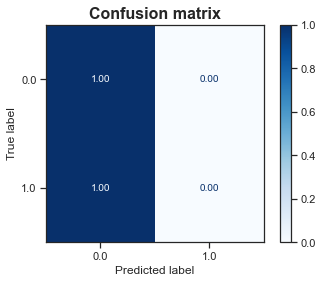

In [114]:
evaluate_model(dummy_classifier, X_test, y_test, threshold_f3)

## KNeighborsClassifier

In [115]:
knn = KNeighborsClassifier()
knn_smote = Pipeline([('smote', smote), ('knn', knn)])
knn_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('knn', KNeighborsClassifier())])

In [116]:
y_pred = knn_smote.predict_proba(X_test)[:,1]
threshold = custom_metric(y_test, y_pred, return_proba=True)[1]


Pour le seuil 0.8, le f3_score est : 0.413 et le mean score est : 0.486


Accuracy score : 0.559834
f3_score : 0.412741 

Mean evalation score : 0.486287


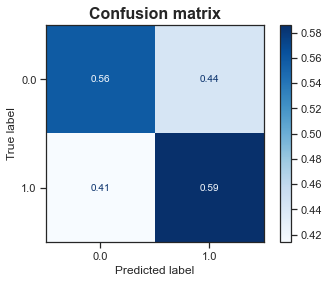

In [104]:
evaluate_model(knn_smote, X_test, y_test, threshold)

In [36]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

def model_optimization(
    model, param_grid,
    X_train=X_train, 
    y_train=y_train, 
    factor=3
):
    """prend en paramètre le modèle, les données de train reéquilibrées et de test
    montre les performances du model après optimisation"""
    
    X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    #définition du pipeline de randomsearchcv
    model_grid = HalvingGridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv, 
        verbose=1, 
        scoring=custom_score,
        random_state=42,
        factor=factor
    )
    
    model_pipeline = Pipeline([('smote', smote), ('model_grid', model_grid)])
    model_pipeline.fit(X_train, y_train)
    
    
    best_prarams = model_pipeline['model_grid'].best_params_
    print(f"Best parameters: {best_prarams}")
    
    best_model = Pipeline([('smote', smote), ('model', model.set_params(**best_prarams))])
    best_model.fit(X_train, y_train)
    
    return best_model

def best_model_evaluation(best_model, X_test=X_test, y_test=y_test):
    
    X_test = X_test.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    threshold = custom_metric(y_test, y_pred_proba, return_proba=True)[1]
    evaluate_model(best_model, X_test, y_test, threshold)
    
def construct_model(model, model_params, X_train=X_train, y_train=y_train):
    
    X_train = X_train.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    model_smote = Pipeline([('smote', smote), ('model', model.set_params(**model_params))])
    
    return model_smote.fit(X_train, y_train)
    

### Optimisation & Evaluation

In [122]:
experiment_id = dict(mlflow.set_experiment("KNeighborsClassifier(1) Hyperparameter Tuning"))['experiment_id']
experiment_id

2023/03/09 23:23:48 INFO mlflow.tracking.fluent: Experiment with name 'KNeighborsClassifier(1) Hyperparameter Tuning' does not exist. Creating a new experiment.


'205842512423992445'

In [140]:
def mlflow_hyperparameter_tuning(experiment_id, params, scores):
    
    with mlflow.start_run(experiment_id=experiment_id):
    
        for param_name, val in params.items():
            mlflow.log_param(param_name, val)
        
        mlflow.log_metric("Mean F3_score", scores.mean())

In [125]:
def knn_objective(trial):
    params = {'n_neighbors' :trial.suggest_int('n_neighbors', 1, 300)}
    
    knn = KNeighborsClassifier(**params)
    model_smote = Pipeline([('smote', smote), ('knn', knn)])
    scores = cross_val_score(
        model_smote, X_train, y_train, cv=cv,
        scoring=custom_score,
        n_jobs=-1,
    )
    
    #send result to mflow
    mlflow_hyperparameter_tuning(experiment_id, params, scores)
    return scores.mean()

knn_params = udf.tune(knn_objective, 100)

[I 2023-03-09 23:34:28,480] A new study created in memory with name: Hyperparameters optimization
[I 2023-03-09 23:34:57,559] Trial 0 finished with value: 0.410662122128674 and parameters: {'n_neighbors': 86}. Best is trial 0 with value: 0.410662122128674.
[I 2023-03-09 23:35:23,936] Trial 1 finished with value: 0.4200960882931901 and parameters: {'n_neighbors': 179}. Best is trial 1 with value: 0.4200960882931901.
[I 2023-03-09 23:35:43,310] Trial 2 finished with value: 0.4233719556912277 and parameters: {'n_neighbors': 282}. Best is trial 2 with value: 0.4233719556912277.
[I 2023-03-09 23:36:05,040] Trial 3 finished with value: 0.4202528695552584 and parameters: {'n_neighbors': 231}. Best is trial 2 with value: 0.4233719556912277.
[I 2023-03-09 23:36:24,011] Trial 4 finished with value: 0.41813404416900646 and parameters: {'n_neighbors': 100}. Best is trial 2 with value: 0.4233719556912277.
[I 2023-03-09 23:36:42,822] Trial 5 finished with value: 0.4263044966862872 and parameters: {'

[I 2023-03-09 23:49:01,834] Trial 46 finished with value: 0.4199309583598458 and parameters: {'n_neighbors': 144}. Best is trial 25 with value: 0.4279717441320986.
[I 2023-03-09 23:49:19,674] Trial 47 finished with value: 0.420237388326887 and parameters: {'n_neighbors': 262}. Best is trial 25 with value: 0.4279717441320986.
[I 2023-03-09 23:49:37,155] Trial 48 finished with value: 0.4209030084953465 and parameters: {'n_neighbors': 228}. Best is trial 25 with value: 0.4279717441320986.
[I 2023-03-09 23:49:56,580] Trial 49 finished with value: 0.4241910294054311 and parameters: {'n_neighbors': 300}. Best is trial 25 with value: 0.4279717441320986.
[I 2023-03-09 23:50:14,875] Trial 50 finished with value: 0.4233719556912277 and parameters: {'n_neighbors': 282}. Best is trial 25 with value: 0.4279717441320986.
[I 2023-03-09 23:50:32,880] Trial 51 finished with value: 0.4279717441320986 and parameters: {'n_neighbors': 200}. Best is trial 25 with value: 0.4279717441320986.
[I 2023-03-09 23:

[I 2023-03-10 00:03:23,805] Trial 93 finished with value: 0.4238012875961673 and parameters: {'n_neighbors': 214}. Best is trial 66 with value: 0.4282242711367899.
[I 2023-03-10 00:03:40,941] Trial 94 finished with value: 0.4279717441320986 and parameters: {'n_neighbors': 200}. Best is trial 66 with value: 0.4282242711367899.
[I 2023-03-10 00:04:02,447] Trial 95 finished with value: 0.4205102535646459 and parameters: {'n_neighbors': 224}. Best is trial 66 with value: 0.4282242711367899.
[I 2023-03-10 00:04:20,737] Trial 96 finished with value: 0.42329261511032756 and parameters: {'n_neighbors': 199}. Best is trial 66 with value: 0.4282242711367899.
[I 2023-03-10 00:04:40,462] Trial 97 finished with value: 0.4215730441032314 and parameters: {'n_neighbors': 174}. Best is trial 66 with value: 0.4282242711367899.
[I 2023-03-10 00:05:02,955] Trial 98 finished with value: 0.42115745505600294 and parameters: {'n_neighbors': 164}. Best is trial 66 with value: 0.4282242711367899.
[I 2023-03-10 

Best score: 0.4282242711367899

Optimized parameters: {'n_neighbors': 187}



In [126]:
#knn_params = {'n_neighbors': 10}
knn_optimized = construct_model(knn, knn_params)
knn_optimized

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model', KNeighborsClassifier(n_neighbors=187))])


Pour le seuil 0.8, le f3_score est : 0.43 et le mean score est : 0.528
Accuracy score : 0.626171
f3_score : 0.430127 

Mean evalation score : 0.528149


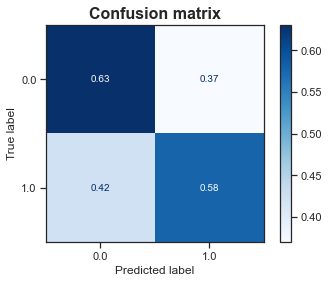

In [127]:
best_model_evaluation(knn_optimized)

## RandomforestClassifier

In [40]:
forest = RandomForestClassifier(n_jobs=-1)
forest_smote = Pipeline([('smote', smote), ('model', forest)])
#forest_smote.fit(X_train, y_train)

In [157]:
y_pred = forest_smote.predict_proba(X_test)[:,1]
threshold_f3 = custom_metric(y_test, y_pred, return_proba=True)[1]


Pour le seuil 0.2, le f3_score est : 0.485 et le mean score est : 0.567


Accuracy score : 0.648283
f3_score : 0.484992 

Mean evalation score : 0.566637


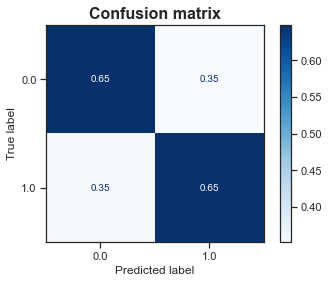

In [158]:
evaluate_model(forest_smote, X_test, y_test, threshold_f3)

### Optimisation & Evaluation

In [159]:
experiment_id = dict(mlflow.set_experiment("Random forest Hyperparameter Tuning"))['experiment_id']
experiment_id

'560907910543854535'

In [162]:
def randomforest_objective(trial):
    
    params = {# Number of trees in random forest
    'n_estimators': trial.suggest_int("n_estimators", 200, 2000),
    # Maximum number of levels in tree
    'max_depth': trial.suggest_int("max_depth", 10, 110, step=10),
    # Minimum number of samples required to split a node
    'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 10),
    # Number of features to consider at every split
    #'max_features': trial.suggest_int("max_features", 10, 211),
    # Method of selecting samples for training each tree
    'bootstrap': trial.suggest_categorical("bootstrap", [True, False])
    }

    clf = RandomForestClassifier( 
        **params, n_jobs=-1, random_state=42,
    )

    forest_smote = Pipeline([('smote', smote), ('model', clf)])
    scores = cross_val_score(
        forest_smote, X_train, y_train, cv=cv,
        scoring=custom_score,
        n_jobs=-1,
    )
    
    #send results to mlflow
    mlflow_hyperparameter_tuning(experiment_id, params, scores)
    
    return scores.mean()

randomforest_params = udf.tune(randomforest_objective, 100)
#forest_optimized = RandomForestClassifier(n_jobs=-1, random_state=42, **randomforest_params)

[I 2023-03-15 22:16:49,192] A new study created in memory with name: Hyperparameters optimization
[I 2023-03-15 22:37:26,121] Trial 0 finished with value: 0.4994731836761683 and parameters: {'n_estimators': 1980, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: 0.4994731836761683.
[I 2023-03-15 22:52:02,481] Trial 1 finished with value: 0.5079081012071365 and parameters: {'n_estimators': 1701, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 1 with value: 0.5079081012071365.
[I 2023-03-15 23:05:21,068] Trial 2 finished with value: 0.48678875750706324 and parameters: {'n_estimators': 1485, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.5079081012071365.
[I 2023-03-15 23:11:51,099] Trial 3 finished with value: 0.38086833081670735 and parameters: {'n_estimators': 1280, 'max_depth': 10, 'min_samples_split': 7, 'mi

[I 2023-03-16 04:12:11,104] Trial 31 finished with value: 0.5091095157382651 and parameters: {'n_estimators': 1998, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 30 with value: 0.5102124522288979.
[I 2023-03-16 04:21:53,423] Trial 32 finished with value: 0.38688776107396927 and parameters: {'n_estimators': 1999, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 30 with value: 0.5102124522288979.
[I 2023-03-16 04:33:01,066] Trial 33 finished with value: 0.5109413888108685 and parameters: {'n_estimators': 1684, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 33 with value: 0.5109413888108685.
[I 2023-03-16 04:44:00,827] Trial 34 finished with value: 0.5082543420883432 and parameters: {'n_estimators': 1676, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 33 with value: 0.5109413888108685.


[I 2023-03-16 09:27:17,796] Trial 63 finished with value: 0.5097595906190076 and parameters: {'n_estimators': 1069, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 33 with value: 0.5109413888108685.
[I 2023-03-16 09:36:42,980] Trial 64 finished with value: 0.5004483114810736 and parameters: {'n_estimators': 1202, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 33 with value: 0.5109413888108685.
[I 2023-03-16 09:43:12,164] Trial 65 finished with value: 0.508335569059112 and parameters: {'n_estimators': 924, 'max_depth': 90, 'min_samples_split': 8, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 33 with value: 0.5109413888108685.
[I 2023-03-16 09:50:56,578] Trial 66 finished with value: 0.5078994125047203 and parameters: {'n_estimators': 1073, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 33 with value: 0.5109413888108685.
[I 20

[I 2023-03-16 13:02:44,306] Trial 95 finished with value: 0.5120884900099126 and parameters: {'n_estimators': 940, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 89 with value: 0.5129666200333695.
[I 2023-03-16 13:07:38,473] Trial 96 finished with value: 0.383090566635086 and parameters: {'n_estimators': 955, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 89 with value: 0.5129666200333695.
[I 2023-03-16 13:13:29,017] Trial 97 finished with value: 0.5123965146271204 and parameters: {'n_estimators': 859, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 89 with value: 0.5129666200333695.
[I 2023-03-16 13:17:56,317] Trial 98 finished with value: 0.3845791478673067 and parameters: {'n_estimators': 868, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 89 with value: 0.5129666200333695.
[I 202

Best score: 0.5129666200333695

Optimized parameters: {'n_estimators': 882, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}



In [42]:
#randomforest_params = {'n_estimators': 690, 'max_depth': 90, 'min_samples_split': 3, 'min_samples_leaf': 7, 'bootstrap': True}
#randomforest_params = {'random_state': 42, 'n_estimators': 633, 'max_depth': 20, 'max_features': 13, 'min_samples_split': 3, 'min_samples_leaf':7, 'bootstrap':True}
randomforest_params = {'n_estimators': 882, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}
randomforest_optimized = construct_model(forest, randomforest_params)
randomforest_optimized

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                                        min_samples_split=6, n_estimators=882,
                                        n_jobs=-1))])


Pour le seuil 0.2, le f3_score est : 0.529 et le mean score est : 0.586
Accuracy score : 0.642494
f3_score : 0.528968 

Mean evalation score : 0.585731


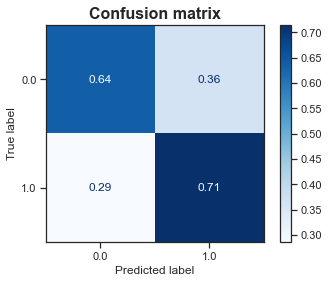

In [43]:
best_model_evaluation(randomforest_optimized)

In [44]:
import pickle
pickle.dump(randomforest_optimized, open(Path(PROJECT_ROOT + '/model_and_data/model.pkl'), 'wb'))


Pour le seuil 0.2, le f3_score est : 0.535 et le mean score est : 0.544
Accuracy score : 0.553070
f3_score : 0.535242 

Mean evalation score : 0.544156


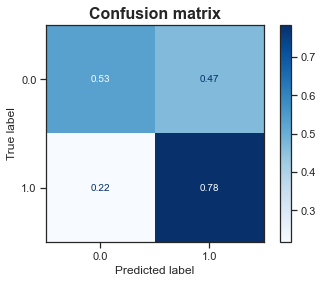

In [164]:
best_model_evaluation(randomforest_optimized)

## Logistic regression

In [135]:
from sklearn.linear_model import LogisticRegression

In [136]:
logistic_regression = LogisticRegression(random_state=42, n_jobs = -1)
logistic_regression_smote = Pipeline([('smote', smote), ('model', logistic_regression)])
logistic_regression_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model', LogisticRegression(n_jobs=-1, random_state=42))])

In [137]:
y_pred_proba = logistic_regression_smote.predict_proba(X_test)[:,1]
threshold_f3 = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.35, le f3_score est : 0.421 et le mean score est : 0.578


Accuracy score : 0.735172
f3_score : 0.420976 

Mean evalation score : 0.578074


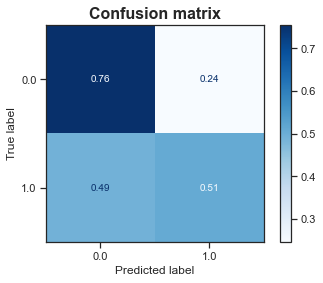

In [138]:
evaluate_model(logistic_regression, X_test, y_test, threshold_f3)

### Optimisation & Evaluation

In [152]:
experiment_id = dict(mlflow.set_experiment("Logistic Regression(1) Hyperparameter Tuning"))['experiment_id']
experiment_id

2023/03/10 09:02:00 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression(1) Hyperparameter Tuning' does not exist. Creating a new experiment.


'153487527092994202'

In [349]:
tracking_uri = mlflow.get_tracking_uri()
tracking_uri

'file:///Users/kone/Desktop/Oc_Formation/Projets/Projet7/openclassrooms_projects7/mlruns'

In [319]:
PROJECT_ROOT

'/Users/kone/Desktop/Oc_Formation/Projets/Projet7/openclassrooms_projects7'

In [153]:
#with mlflow.start_run(experiment_id='844779971019835314'):
def logistic_regression_objective(trial):
    #_l1_ratio = trial.suggest_float("l1_ratio", 0., 1)
    #_C = trial.suggest_float("C", 0.00001, 0.9901)
    #_max_iter = trial.suggest_int("max_iter", 50, 500)
    #_penalty = trial.suggest_categorical("penalty", ['l1', 'l2'])


    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-10 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-10, 1),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1'])
    }
    if params['penalty'] == 'l1':
        params['solver'] = 'saga'
    else:
        params['solver'] = 'lbfgs'

    logistic_regression = LogisticRegression(
        **params, random_state=42, n_jobs=-1
    )
    logistic_regression_smote = Pipeline([('smote', smote), ('model', logistic_regression)])

    scores = cross_val_score(
        logistic_regression_smote, X_train, y_train, cv=cv,
        scoring=custom_score,
        n_jobs=-1,
    )
    
    mlflow_hyperparameter_tuning(experiment_id, params, scores)
        
    return scores.mean()

logistic_regression_params = udf.tune(logistic_regression_objective, 300)

[I 2023-03-10 09:04:02,294] A new study created in memory with name: Hyperparameters optimization
[I 2023-03-10 09:04:27,553] Trial 0 finished with value: 0.48679030538668383 and parameters: {'tol': 0.0006053210318339322, 'C': 2.588971334664364e-05, 'penalty': 'l2'}. Best is trial 0 with value: 0.48679030538668383.
[I 2023-03-10 09:04:35,249] Trial 1 finished with value: 0.5006433490036858 and parameters: {'tol': 0.0009286932616491065, 'C': 1.5977683192025823e-10, 'penalty': 'l2'}. Best is trial 1 with value: 0.5006433490036858.
[I 2023-03-10 09:04:43,003] Trial 2 finished with value: 0.0 and parameters: {'tol': 0.0007466072735738306, 'C': 1.7919669679581004e-05, 'penalty': 'l1'}. Best is trial 1 with value: 0.5006433490036858.
[I 2023-03-10 09:04:50,663] Trial 3 finished with value: 0.0 and parameters: {'tol': 0.0006562246904114321, 'C': 1.5552480524189524e-06, 'penalty': 'l1'}. Best is trial 1 with value: 0.5006433490036858.
[I 2023-03-10 09:04:56,474] Trial 4 finished with value: 0.

[I 2023-03-10 09:09:10,454] Trial 36 finished with value: 0.4660709156227038 and parameters: {'tol': 0.00019786898777252645, 'C': 6.660612133529707e-07, 'penalty': 'l2'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:09:15,129] Trial 37 finished with value: 0.0 and parameters: {'tol': 8.484843499870035e-05, 'C': 2.439954915295275e-10, 'penalty': 'l1'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:09:19,692] Trial 38 finished with value: 0.4995999556078067 and parameters: {'tol': 0.00014643278760771534, 'C': 9.066915155093566e-08, 'penalty': 'l2'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:09:23,914] Trial 39 finished with value: 0.0 and parameters: {'tol': 0.0003401132706648693, 'C': 1.284170872212576e-05, 'penalty': 'l1'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:09:28,066] Trial 40 finished with value: 0.5006597897348499 and parameters: {'tol': 0.00022469313673053584, 'C': 1.200879877986649e-08, 'pe

[I 2023-03-10 09:12:01,923] Trial 72 finished with value: 0.500796996639121 and parameters: {'tol': 0.00019764360020317894, 'C': 6.54654261909714e-08, 'penalty': 'l2'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:12:07,773] Trial 73 finished with value: 0.465336045027389 and parameters: {'tol': 0.00013683675527849514, 'C': 1.365269937336901e-07, 'penalty': 'l2'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:12:12,536] Trial 74 finished with value: 0.5006597897348499 and parameters: {'tol': 0.00019645671164690313, 'C': 2.1368109180370192e-08, 'penalty': 'l2'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:12:17,238] Trial 75 finished with value: 0.4995300777317415 and parameters: {'tol': 0.000232028109963719, 'C': 8.08391410018162e-08, 'penalty': 'l2'}. Best is trial 11 with value: 0.500796996639121.
[I 2023-03-10 09:12:21,955] Trial 76 finished with value: 0.46634678806274976 and parameters: {'tol': 0.0001761921123726373, 'C':

[I 2023-03-10 09:14:41,522] Trial 108 finished with value: 0.5006597897348499 and parameters: {'tol': 0.0003447314581295542, 'C': 4.513871907567841e-09, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:14:45,958] Trial 109 finished with value: 0.4654380584676817 and parameters: {'tol': 0.0002934880502003474, 'C': 2.0247499910545657e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:14:50,130] Trial 110 finished with value: 0.48605106975661555 and parameters: {'tol': 0.0002335659628789107, 'C': 1.0427490286120208e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:14:54,557] Trial 111 finished with value: 0.5007787392631109 and parameters: {'tol': 0.0002556809674473114, 'C': 6.090881359970626e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:14:59,998] Trial 112 finished with value: 0.5007449180911484 and parameters: {'tol': 0.00032002852451696

[I 2023-03-10 09:17:16,737] Trial 144 finished with value: 0.46634578481534106 and parameters: {'tol': 0.00020211011833594508, 'C': 2.830502186287915e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:17:20,001] Trial 145 finished with value: 0.4995999556078067 and parameters: {'tol': 0.00022692619453656084, 'C': 9.201667411353887e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:17:23,215] Trial 146 finished with value: 0.500694487153105 and parameters: {'tol': 0.0001557951516030696, 'C': 2.5467093422299445e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:17:26,974] Trial 147 finished with value: 0.5006597897348499 and parameters: {'tol': 0.00010206085688698569, 'C': 1.2571036558279394e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:17:30,417] Trial 148 finished with value: 0.5007279257524541 and parameters: {'tol': 0.000127946475975

[I 2023-03-10 09:19:19,287] Trial 180 finished with value: 0.5007109391924841 and parameters: {'tol': 0.00016750398559057476, 'C': 4.001003497175076e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:19:22,314] Trial 181 finished with value: 0.500813994759489 and parameters: {'tol': 0.00028790137406179133, 'C': 6.762945184295951e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:19:25,678] Trial 182 finished with value: 0.4998566201010576 and parameters: {'tol': 0.0002558341206180413, 'C': 7.783083327070533e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:19:29,441] Trial 183 finished with value: 0.465336045027389 and parameters: {'tol': 0.0002684028676048452, 'C': 1.3633979484091216e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:19:32,719] Trial 184 finished with value: 0.5007787392631109 and parameters: {'tol': 0.0002390456600500002

[I 2023-03-10 09:21:22,121] Trial 216 finished with value: 0.46542253231881203 and parameters: {'tol': 0.0002487099264169961, 'C': 1.5624723736955534e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:21:25,292] Trial 217 finished with value: 0.500796996639121 and parameters: {'tol': 0.0001961306364304123, 'C': 6.523365036949941e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:21:28,520] Trial 218 finished with value: 0.500694487153105 and parameters: {'tol': 0.00014678203227715938, 'C': 3.227152203393341e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:21:32,197] Trial 219 finished with value: 0.48605106975661555 and parameters: {'tol': 0.00019827860913179955, 'C': 1.0422433806524744e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:21:35,740] Trial 220 finished with value: 0.4659535431002789 and parameters: {'tol': 0.0003694988932447

[I 2023-03-10 09:23:24,065] Trial 252 finished with value: 0.500796996639121 and parameters: {'tol': 0.00036711242462890404, 'C': 6.574779812746902e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:23:27,143] Trial 253 finished with value: 0.500694487153105 and parameters: {'tol': 0.00037253776391211514, 'C': 3.389096126829028e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:23:30,418] Trial 254 finished with value: 0.4998566201010576 and parameters: {'tol': 0.0001982176952961814, 'C': 7.954408352057616e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:23:34,035] Trial 255 finished with value: 0.4664310649835725 and parameters: {'tol': 0.00023830220508251027, 'C': 4.539847633499402e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:23:37,737] Trial 256 finished with value: 0.46545480306461184 and parameters: {'tol': 0.000218604670267102

[I 2023-03-10 09:25:27,474] Trial 288 finished with value: 0.4995999556078067 and parameters: {'tol': 0.0002281583531584909, 'C': 9.012833754147787e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:25:30,735] Trial 289 finished with value: 0.500694487153105 and parameters: {'tol': 0.0002660738167869816, 'C': 3.721676034924772e-08, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:25:38,389] Trial 290 finished with value: 0.4507858514119737 and parameters: {'tol': 0.0002091544491825439, 'C': 0.015856667657610343, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:25:42,103] Trial 291 finished with value: 0.4662767149482027 and parameters: {'tol': 0.00023833116832060988, 'C': 2.456393267286955e-07, 'penalty': 'l2'}. Best is trial 91 with value: 0.500813994759489.
[I 2023-03-10 09:25:45,463] Trial 292 finished with value: 0.5007622815652489 and parameters: {'tol': 0.0003051916807093552, 

Best score: 0.500813994759489

Optimized parameters: {'tol': 0.0002329433780056682, 'C': 6.681553108313681e-08, 'penalty': 'l2'}



In [154]:
logistic_regression_params

{'tol': 0.0002329433780056682, 'C': 6.681553108313681e-08, 'penalty': 'l2'}

Best score: 0.4995235299332249

Optimized parameters: {'tol': 0.00019002996404617352, 'C': 0.00010206877916671905, 'solver': 'lbfgs'}

In [155]:
#logistic_regression_params = {'tol': 0.00019002996404617352, 'C': 0.00010206877916671905, 'solver': 'lbfgs'}
logistic_regression_optimized = construct_model(logistic_regression, logistic_regression_params)
logistic_regression_optimized

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 LogisticRegression(C=6.681553108313681e-08, n_jobs=-1,
                                    random_state=42,
                                    tol=0.0002329433780056682))])


Pour le seuil 0.5, le f3_score est : 0.48 et le mean score est : 0.529
Accuracy score : 0.578044
f3_score : 0.479694 

Mean evalation score : 0.528869


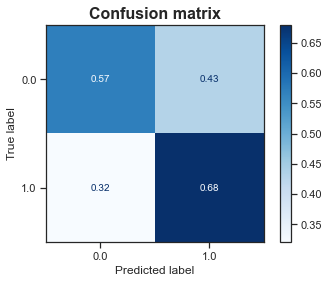

In [156]:
best_model_evaluation(logistic_regression_optimized)

## LightGBM

In [129]:
from lightgbm import LGBMClassifier

In [130]:
#LightGBM classifier
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [131]:
lgbm = LGBMClassifier(random_state=42, n_jobs=-1, boosting_type='rf')
lgbm_smote = Pipeline([('smote', smote), ('model', lgbm)])
lgbm_smote.fit(X_train, y_train)

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /tmp/pip-req-build-tbfphzo4/compile/src/boosting/rf.hpp, line 35 .



LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /tmp/pip-req-build-tbfphzo4/compile/src/boosting/rf.hpp, line 35 .


In [165]:
y_pred_proba = lgbm_smote.predict_proba(X_test)[:,1]
threshold_f3 = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.2, le f3_score est : 0.33 et le mean score est : 0.601


Accuracy score : 0.872268
f3_score : 0.330425 

Mean evalation score : 0.601347


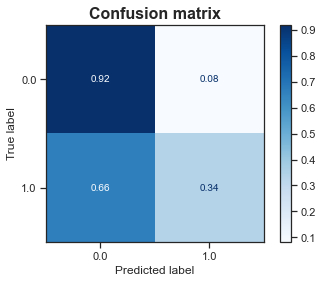

In [166]:
evaluate_model(lgbm_smote, X_test, y_test, threshold_f3)

### Optimisation & Evaluation

In [167]:
experiment_id = dict(mlflow.set_experiment("LightGBM Hyperparameter(1) Tuning"))['experiment_id']
experiment_id

'500409515578582350'

In [168]:
def lgbm_objective(trial):
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300 ,2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.9, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
    }
    
    lgbm = LGBMClassifier(**params, random_state=42, n_jobs=-1)
    logistic_regression = Pipeline([('smote', smote), ('model', lgbm)])
    
    scores = cross_val_score(
        logistic_regression, X_train, y_train, cv=cv, scoring=custom_score, n_jobs=-1
                             
    )
    
    mlflow_hyperparameter_tuning(experiment_id, params, scores)
    
    return scores.mean()

lgbm_params = udf.tune(lgbm_objective, 100)

[I 2023-03-10 09:35:24,580] A new study created in memory with name: Hyperparameters optimization
[I 2023-03-10 09:36:56,470] Trial 0 finished with value: 0.4261745197517476 and parameters: {'n_estimators': 897, 'learning_rate': 0.08178609709380619, 'num_leaves': 2120, 'max_depth': 10, 'min_data_in_leaf': 300, 'max_bin': 227, 'lambda_l1': 50, 'lambda_l2': 25, 'min_gain_to_split': 14.480398448018658, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.4261745197517476.
[I 2023-03-10 09:37:44,225] Trial 1 finished with value: 0.45981360658307285 and parameters: {'n_estimators': 1593, 'learning_rate': 0.12645911392074313, 'num_leaves': 1720, 'max_depth': 4, 'min_data_in_leaf': 6700, 'max_bin': 232, 'lambda_l1': 40, 'lambda_l2': 20, 'min_gain_to_split': 4.843563335373039, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.45981360658307285.
[I 2023-03-10 09:38:30,7

[I 2023-03-10 09:50:57,662] Trial 19 finished with value: 0.46009810207795027 and parameters: {'n_estimators': 1296, 'learning_rate': 0.03551267846053546, 'num_leaves': 1260, 'max_depth': 11, 'min_data_in_leaf': 9800, 'max_bin': 215, 'lambda_l1': 90, 'lambda_l2': 85, 'min_gain_to_split': 8.435551667038133, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 09:51:24,791] Trial 20 finished with value: 0.4788380897254839 and parameters: {'n_estimators': 1393, 'learning_rate': 0.09623583930134352, 'num_leaves': 1160, 'max_depth': 9, 'min_data_in_leaf': 300, 'max_bin': 209, 'lambda_l1': 70, 'lambda_l2': 60, 'min_gain_to_split': 12.555691659648055, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 09:52:18,186] Trial 21 finished with value: 0.46916726878025783 and parameters: {'n_estimators': 1579, 'learning_rate': 0.05317466691510

[I 2023-03-10 10:04:33,531] Trial 38 finished with value: 0.49720550476453085 and parameters: {'n_estimators': 912, 'learning_rate': 0.029624531074585483, 'num_leaves': 1840, 'max_depth': 7, 'min_data_in_leaf': 1500, 'max_bin': 223, 'lambda_l1': 85, 'lambda_l2': 90, 'min_gain_to_split': 7.709304447477036, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.532015131356277.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.480398448018658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480398448018658
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[L

[I 2023-03-10 10:04:52,570] Trial 39 finished with value: 0.489312539051863 and parameters: {'n_estimators': 600, 'learning_rate': 0.04666887712265774, 'num_leaves': 2800, 'max_depth': 10, 'min_data_in_leaf': 2300, 'max_bin': 217, 'lambda_l1': 60, 'lambda_l2': 75, 'min_gain_to_split': 9.366316484154778, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.532015131356277.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.480398448018658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480398448018658
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[L

[I 2023-03-10 10:05:28,193] Trial 40 finished with value: 0.4347161140404999 and parameters: {'n_estimators': 1177, 'learning_rate': 0.07666201609688766, 'num_leaves': 1920, 'max_depth': 3, 'min_data_in_leaf': 3300, 'max_bin': 211, 'lambda_l1': 75, 'lambda_l2': 95, 'min_gain_to_split': 8.901017463427527, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 10:05:45,292] Trial 41 finished with value: 0.5156048484075533 and parameters: {'n_estimators': 804, 'learning_rate': 0.06939222240027774, 'num_leaves': 2000, 'max_depth': 8, 'min_data_in_leaf': 900, 'max_bin': 235, 'lambda_l1': 85, 'lambda_l2': 85, 'min_gain_to_split': 8.806760018674924, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.532015131356277.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.714406546622209, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.714406546622209
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.37752172837970

[I 2023-03-10 10:06:04,802] Trial 42 finished with value: 0.523130045631371 and parameters: {'n_estimators': 862, 'learning_rate': 0.049182708520117885, 'num_leaves': 2120, 'max_depth': 8, 'min_data_in_leaf': 800, 'max_bin': 250, 'lambda_l1': 95, 'lambda_l2': 85, 'min_gain_to_split': 10.00593329832756, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 10:06:25,372] Trial 43 finished with value: 0.5076877206127782 and parameters: {'n_estimators': 774, 'learning_rate': 0.06494028931835684, 'num_leaves': 2180, 'max_depth': 8, 'min_data_in_leaf': 700, 'max_bin': 263, 'lambda_l1': 95, 'lambda_l2': 85, 'min_gain_to_split': 10.045969480496892, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 10:06:43,583] Trial 44 finished with value: 0.4752177046717022 and parameters: {'n_estimators': 855, 'learning_rate': 0.06036

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.843563335373039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.843563335373039
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.71440654662220

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.480398448018658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480398448018658
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[L

[I 2023-03-10 10:07:37,746] Trial 46 finished with value: 0.48769818483702226 and parameters: {'n_estimators': 994, 'learning_rate': 0.044229891499706284, 'num_leaves': 2300, 'max_depth': 6, 'min_data_in_leaf': 3000, 'max_bin': 250, 'lambda_l1': 65, 'lambda_l2': 80, 'min_gain_to_split': 7.6486501190342, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.532015131356277.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.480398448018658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480398448018658
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[L

[I 2023-03-10 10:08:09,976] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 1364, 'learning_rate': 0.02620231582813567, 'num_leaves': 2140, 'max_depth': 8, 'min_data_in_leaf': 3900, 'max_bin': 234, 'lambda_l1': 95, 'lambda_l2': 65, 'min_gain_to_split': 8.266198692510097, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 10:08:22,908] Trial 48 finished with value: 0.460839699329396 and parameters: {'n_estimators': 432, 'learning_rate': 0.023143105262958357, 'num_leaves': 1680, 'max_depth': 9, 'min_data_in_leaf': 7900, 'max_bin': 271, 'lambda_l1': 80, 'lambda_l2': 45, 'min_gain_to_split': 10.793089987573836, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 10:08:39,322] Trial 49 finished with value: 0.42363403366204616 and parameters: {'n_estimators': 1174, 'learning_rate': 0.0538972789600252

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.480398448018658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480398448018658
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[L

[I 2023-03-10 10:09:15,450] Trial 51 finished with value: 0.5187721869075177 and parameters: {'n_estimators': 922, 'learning_rate': 0.04369197284387442, 'num_leaves': 1900, 'max_depth': 9, 'min_data_in_leaf': 600, 'max_bin': 225, 'lambda_l1': 85, 'lambda_l2': 95, 'min_gain_to_split': 9.163659499009299, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.532015131356277.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.354187021237242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.354187021237242
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.12576118829566

[I 2023-03-10 10:09:52,498] Trial 52 finished with value: 0.5165636332633374 and parameters: {'n_estimators': 1068, 'learning_rate': 0.04252122111641898, 'num_leaves': 1920, 'max_depth': 9, 'min_data_in_leaf': 1300, 'max_bin': 227, 'lambda_l1': 80, 'lambda_l2': 90, 'min_gain_to_split': 8.81851972700013, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 10:10:35,559] Trial 53 finished with value: 0.47669239044878875 and parameters: {'n_estimators': 1072, 'learning_rate': 0.04171057564709913, 'num_leaves': 1580, 'max_depth': 9, 'min_data_in_leaf': 500, 'max_bin': 285, 'lambda_l1': 65, 'lambda_l2': 100, 'min_gain_to_split': 9.661731587227322, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 0.532015131356277.
[I 2023-03-10 10:11:46,529] Trial 54 finished with value: 0.521235809705676 and parameters: {'n_estimators

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=9.160904726733504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.160904726733504
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warn

[I 2023-03-10 10:30:24,229] Trial 71 finished with value: 0.5207704021864202 and parameters: {'n_estimators': 1407, 'learning_rate': 0.01094997462433497, 'num_leaves': 1680, 'max_depth': 11, 'min_data_in_leaf': 1200, 'max_bin': 295, 'lambda_l1': 90, 'lambda_l2': 80, 'min_gain_to_split': 4.295837456332624, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 61 with value: 0.5321268955655543.


[LightGBM] [Warning] min_gain_to_split is set=10.408877168713527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.408877168713527
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=13.124149292158403, min_split_gain=0.0 will be ignored. Cu

[I 2023-03-10 10:31:39,268] Trial 72 finished with value: 0.4646447218844222 and parameters: {'n_estimators': 1643, 'learning_rate': 0.011644473381617577, 'num_leaves': 1740, 'max_depth': 11, 'min_data_in_leaf': 1300, 'max_bin': 292, 'lambda_l1': 100, 'lambda_l2': 70, 'min_gain_to_split': 4.721832441671047, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:32:51,805] Trial 73 finished with value: 0.5277899338777665 and parameters: {'n_estimators': 1221, 'learning_rate': 0.018136351280355803, 'num_leaves': 1480, 'max_depth': 12, 'min_data_in_leaf': 800, 'max_bin': 289, 'lambda_l1': 95, 'lambda_l2': 75, 'min_gain_to_split': 6.560367156525831, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:33:59,276] Trial 74 finished with value: 0.5241056326888902 and parameters: {'n_e

[LightGBM] [Warning] min_gain_to_split is set=10.408877168713527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.408877168713527
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=13.124149292158403, min_split_gain=0.0 will be ignored. Cu

[I 2023-03-10 10:35:03,890] Trial 75 finished with value: 0.5249260989595693 and parameters: {'n_estimators': 1198, 'learning_rate': 0.022853881269465293, 'num_leaves': 1000, 'max_depth': 12, 'min_data_in_leaf': 700, 'max_bin': 297, 'lambda_l1': 95, 'lambda_l2': 75, 'min_gain_to_split': 7.311783634613598, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 61 with value: 0.5321268955655543.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=13.124149292158403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.124149292158403
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_freq is 

[I 2023-03-10 10:36:26,728] Trial 76 finished with value: 0.5099860387550963 and parameters: {'n_estimators': 1310, 'learning_rate': 0.020030773670411374, 'num_leaves': 980, 'max_depth': 12, 'min_data_in_leaf': 500, 'max_bin': 299, 'lambda_l1': 100, 'lambda_l2': 75, 'min_gain_to_split': 6.660797217998123, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:37:31,978] Trial 77 finished with value: 0.3838953421582518 and parameters: {'n_estimators': 1176, 'learning_rate': 0.031950162631667944, 'num_leaves': 820, 'max_depth': 12, 'min_data_in_leaf': 400, 'max_bin': 296, 'lambda_l1': 0, 'lambda_l2': 60, 'min_gain_to_split': 7.275152644360245, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 61 with value: 0.5321268955655543.


[LightGBM] [Warning] min_gain_to_split is set=14.177447476422731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.177447476422731
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=9.160904726733504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.16

[I 2023-03-10 10:38:36,296] Trial 78 finished with value: 0.5273827972779422 and parameters: {'n_estimators': 1249, 'learning_rate': 0.020727980940503363, 'num_leaves': 1160, 'max_depth': 12, 'min_data_in_leaf': 900, 'max_bin': 290, 'lambda_l1': 95, 'lambda_l2': 75, 'min_gain_to_split': 6.7417858711701815, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:39:40,688] Trial 79 finished with value: 0.5269508344877444 and parameters: {'n_estimators': 1124, 'learning_rate': 0.03664723675716608, 'num_leaves': 1060, 'max_depth': 12, 'min_data_in_leaf': 800, 'max_bin': 291, 'lambda_l1': 95, 'lambda_l2': 65, 'min_gain_to_split': 7.338476327744897, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 61 with value: 0.5321268955655543.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=9.366316484154778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.366316484154778
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_

[I 2023-03-10 10:40:36,787] Trial 80 finished with value: 0.4428115062713392 and parameters: {'n_estimators': 1139, 'learning_rate': 0.035977222166728995, 'num_leaves': 1060, 'max_depth': 12, 'min_data_in_leaf': 2000, 'max_bin': 289, 'lambda_l1': 95, 'lambda_l2': 65, 'min_gain_to_split': 6.105502567908601, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:41:32,986] Trial 81 finished with value: 0.5265807335957475 and parameters: {'n_estimators': 1206, 'learning_rate': 0.024098816701524205, 'num_leaves': 1140, 'max_depth': 12, 'min_data_in_leaf': 900, 'max_bin': 297, 'lambda_l1': 95, 'lambda_l2': 70, 'min_gain_to_split': 6.960297161379451, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:42:35,747] Trial 82 finished with value: 0.5295272084153119 and parameters: {'n_es

[LightGBM] [Warning] min_gain_to_split is set=9.841125421099212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.841125421099212
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.709304447477036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.709304447477036
[LightGBM] [Warnin

[I 2023-03-10 10:44:31,619] Trial 84 finished with value: 0.5027320884329293 and parameters: {'n_estimators': 1201, 'learning_rate': 0.025244791469534407, 'num_leaves': 920, 'max_depth': 12, 'min_data_in_leaf': 800, 'max_bin': 296, 'lambda_l1': 90, 'lambda_l2': 60, 'min_gain_to_split': 6.992143785271957, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:45:44,216] Trial 85 finished with value: 0.38149433645345815 and parameters: {'n_estimators': 1282, 'learning_rate': 0.017740753529492066, 'num_leaves': 700, 'max_depth': 12, 'min_data_in_leaf': 300, 'max_bin': 280, 'lambda_l1': 5, 'lambda_l2': 55, 'min_gain_to_split': 5.738701025247641, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 61 with value: 0.5321268955655543.
[I 2023-03-10 10:45:59,655] Trial 86 finished with value: 0.0 and parameters: {'n_estimators': 1156, 'learning_rate': 0.04973192445341

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.727578365007922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.727578365007922
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] 

[I 2023-03-10 10:59:44,096] Trial 98 finished with value: 0.4553710088759867 and parameters: {'n_estimators': 1520, 'learning_rate': 0.048820302033762836, 'num_leaves': 880, 'max_depth': 11, 'min_data_in_leaf': 500, 'max_bin': 288, 'lambda_l1': 100, 'lambda_l2': 60, 'min_gain_to_split': 5.482264770351104, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5326298400437173.
[I 2023-03-10 11:00:45,072] Trial 99 finished with value: 0.5265335468582938 and parameters: {'n_estimators': 1305, 'learning_rate': 0.03042597557604193, 'num_leaves': 1100, 'max_depth': 11, 'min_data_in_leaf': 600, 'max_bin': 293, 'lambda_l1': 100, 'lambda_l2': 75, 'min_gain_to_split': 6.278510578880634, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5326298400437173.


Best score: 0.5326298400437173

Optimized parameters: {'n_estimators': 1379, 'learning_rate': 0.0305180705872894, 'num_leaves': 1340, 'max_depth': 11, 'min_data_in_leaf': 200, 'max_bin': 274, 'lambda_l1': 100, 'lambda_l2': 80, 'min_gain_to_split': 5.6169036486489725, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.234667778269985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.234667778269985
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be 

[LightGBM] [Warning] min_gain_to_split is set=5.288286603429221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.288286603429221
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.902837147857241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.902837147857241
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.957338925504859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.957338925504859
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warn

[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=7.340711260613811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.340711260613811
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fr

[LightGBM] [Warning] min_gain_to_split is set=5.902837147857241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.902837147857241
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.908855597102384, min_split_gain=0.0 will be ignored. Cur

[LightGBM] [Warning] min_gain_to_split is set=8.098839122229055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.098839122229055
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.637692531668317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.63

[LightGBM] [Warning] min_gain_to_split is set=5.902837147857241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.902837147857241
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.298370467092901, min_split_gain=0.0 will be ignored. Cur

In [132]:
lgbm_params = {'n_estimators': 1379,
 'learning_rate': 0.0305180705872894,
 'num_leaves': 1340,
 'max_depth': 11,
 'min_data_in_leaf': 200,
 'max_bin': 274,
 'lambda_l1': 100,
 'lambda_l2': 80,
 'min_gain_to_split': 5.6169036486489725,
 'bagging_fraction': 0.30000000000000004,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}

In [133]:
#lgbm_params = {'n_estimators': 976, 'learning_rate': 0.10450965412733053, 'num_leaves': 2060, 'max_depth': 9, 'min_data_in_leaf': 1200, 'max_bin': 226, 'lambda_l1': 95, 'lambda_l2': 70, 'min_gain_to_split': 13.913532191157262, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}
lgdm_optimized = construct_model(lgbm, lgbm_params)
lgdm_optimized

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 LGBMClassifier(bagging_fraction=0.30000000000000004,
                                bagging_freq=1, boosting_type='rf',
                                feature_fraction=0.30000000000000004,
                                lambda_l1=100, lambda_l2=80,
                                learning_rate=0.0305180705872894, max_bin=274,
                                max_depth=11, min_data_in_leaf=200,
                                min_gain_to_split=5.6169036486489725,
                                n_estimators=1379, num_leaves=1340,
                                random_state=42))])


Pour le seuil 0.5, le f3_score est : 0.162 et le mean score est : 0.523
Accuracy score : 0.884235
f3_score : 0.161716 

Mean evalation score : 0.522976


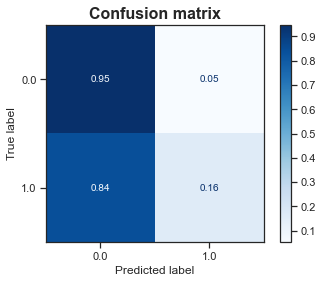

In [134]:
best_model_evaluation(lgdm_optimized)


Pour le seuil 0.2, le f3_score est : 0.511 et le mean score est : 0.582
Accuracy score : 0.652706
f3_score : 0.511038 

Mean evalation score : 0.581872


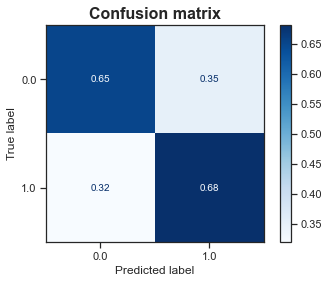

In [171]:
best_model_evaluation(lgdm_optimized)

In [ ]:
#optimisation d'hyperparametres du LGBMClassifier
param_grid = {
    #structural parameter
    'num_leaves' :[int(n) for n in np.linspace(start = 20, stop = 3000, num=5)],
    'max_depth' :[int(n) for n in np.linspace(start = 3, stop = 12, num=5)],
    'min_child_weight' :np.linspace(start = 10, stop = 50, num=5)

    #Hyperparameters for better accuracy
    'n_estimators': [int(n) for n in np.linspace(start = 100, stop = 500, num=5)],
    'learning_rate' : np.linspace(start = 0.01, stop = 0.3, num=5),

    #hyperparameters to control overfitting
    'lambda_l1' :np.linspace(start = 0, stop = 100, num=5),
    'lambda_l2' :np.linspace(start = 0, stop = 100, num=5),
    'min_gain_to_split' :np.linspace(start = 0, stop = 15, num=5)
    'bagging_fraction' : np.linspace(start = 0, stop = 1, num=5),
    'max_bin' : np.linspace(start = 200, stop = 300, num=5)
    'feature_fraction' :np.linspace(start = 0, stop = 1, num=5),
    #other hyperparameters
    'colsample_bytree' :np.linspace(start = 0.5, stop = 0.99, num=5),
    'subsample' :np.linspace(start = 0.5, stop = 0.99, num=5),

    #'min_split_gain':np.linspace(start = 0.01, stop = 0.05, num=5),
    
}

optimize_model(lgbm, param_grid)


Pour le seuil 0.8, le f3_score est : 0.986 et le mean score est : 0.954

Pour le seuil 0.8, le f3_score est : 0.977 et le mean score est : 0.926

Pour le seuil 0.8, le f3_score est : 0.977 et le mean score est : 0.925

Pour le seuil 0.8, le f3_score est : 0.984 et le mean score est : 0.95

Pour le seuil 0.8, le f3_score est : 0.965 et le mean score est : 0.887

Pour le seuil 0.8, le f3_score est : 0.966 et le mean score est : 0.888

Pour le seuil 0.8, le f3_score est : 0.981 et le mean score est : 0.944

Pour le seuil 0.8, le f3_score est : 0.967 et le mean score est : 0.904

Pour le seuil 0.8, le f3_score est : 0.968 et le mean score est : 0.904

Pour le seuil 0.8, le f3_score est : 0.967 et le mean score est : 0.903

Pour le seuil 0.8, le f3_score est : 0.966 et le mean score est : 0.899

Pour le seuil 0.8, le f3_score est : 0.979 et le mean score est : 0.952

Pour le seuil 0.8, le f3_score est : 0.98 et le mean score est : 0.948

Pour le seuil 0.8, le f3_score est : 0.959 et le mea


Pour le seuil 0.8, le f3_score est : 0.974 et le mean score est : 0.915

Pour le seuil 0.8, le f3_score est : 0.974 et le mean score est : 0.914

Pour le seuil 0.8, le f3_score est : 0.987 et le mean score est : 0.962

Pour le seuil 0.8, le f3_score est : 0.969 et le mean score est : 0.907

Pour le seuil 0.8, le f3_score est : 0.971 et le mean score est : 0.909

Pour le seuil 0.8, le f3_score est : 0.971 et le mean score est : 0.906

Pour le seuil 0.8, le f3_score est : 0.97 et le mean score est : 0.905

Pour le seuil 0.8, le f3_score est : 0.972 et le mean score est : 0.909

Pour le seuil 0.8, le f3_score est : 0.977 et le mean score est : 0.937

Pour le seuil 0.8, le f3_score est : 0.98 et le mean score est : 0.943

Pour le seuil 0.8, le f3_score est : 0.969 et le mean score est : 0.905

Pour le seuil 0.8, le f3_score est : 0.982 et le mean score est : 0.958

Pour le seuil 0.8, le f3_score est : 0.98 et le mean score est : 0.951

Pour le seuil 0.8, le f3_score est : 0.969 et le mean

## SVC

In [48]:
from sklearn.svm import LinearSVC

In [51]:
svc = LinearSVC(random_state=42)
svc_smote = Pipeline([('smote', smote), ('model', svc)])
svc_smote.fit(X_train, y_train)

/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model', LinearSVC(random_state=42))])

In [52]:
y_pred_proba = svc_smote.predict_proba(X_test)[:,1]

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [44]:
threshold = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.2, le f3_score est : 0.263 et le mean score est : 0.554


Accuracy score : 0.845734
f3_score : 0.262825 

Mean evalation score : 0.554279


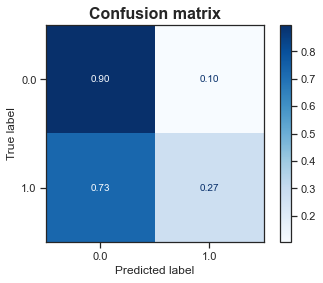

In [45]:
evaluate_model(svc_smote, X_test, y_test, threshold)

In [ ]:
#kernel parameters selects the type of hyperplane
#kernels = [‘linear’, ‘rbf’, ‘poly’]

#if non linear hyperplanes
gammas = [0.1, 1, 10, 100] #gamma leads to overfitting

#It controls the trade off between smooth decision boundary and classifying the training points correctly.
#C = = [0.1, 1, 10, 100, 1000]#may lead to overfitting the training data.

#when kernel is set to ‘poly’.
#degree== [0, 1, 2, 3, 4, 5, 6]#degree=1 is the same as using a ‘linear’ kernel

### Optimisation

## StackingClassifier

In [53]:
from sklearn.ensemble import StackingClassifier

In [62]:
lgbm_params = {'n_estimators': 1379,
 'learning_rate': 0.0305180705872894,
 'num_leaves': 1340,
 'max_depth': 11,
 'min_data_in_leaf': 200,
 'max_bin': 274,
 'lambda_l1': 100,
 'lambda_l2': 80,
 'min_gain_to_split': 5.6169036486489725,
 'bagging_fraction': 0.30000000000000004,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}

lgbm = LGBMClassifier(**lgbm_params,random_state=42, n_jobs=-1)
#lgdm_optimized = construct_model(lgbm, lgbm_params)
#lgdm_optimized
lgbm

LGBMClassifier(bagging_fraction=0.30000000000000004, bagging_freq=1,
               feature_fraction=0.30000000000000004, lambda_l1=100,
               lambda_l2=80, learning_rate=0.0305180705872894, max_bin=274,
               max_depth=11, min_data_in_leaf=200,
               min_gain_to_split=5.6169036486489725, n_estimators=1379,
               num_leaves=1340, random_state=42)

In [63]:
from sklearn.ensemble import RandomForestClassifier

randomforest_params = {
    'n_estimators': 690, 
    'max_depth': 90, 
    'min_samples_split': 3, 
    'min_samples_leaf': 7, 
    'bootstrap': True
}
randomforest = RandomForestClassifier(random_state=42, n_jobs=-1, **randomforest_params)
randomforest

RandomForestClassifier(max_depth=90, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=690, n_jobs=-1, random_state=42)

In [65]:
from sklearn.linear_model import LogisticRegression

logisticregression_params = {
    'tol': 0.0002329433780056682, 
    'C': 6.681553108313681e-08, 
    'penalty': 'l2'
}

logisticregression = LogisticRegression(random_state=42, n_jobs=-1, **logisticregression_params)
logisticregression

LogisticRegression(C=6.681553108313681e-08, n_jobs=-1, random_state=42,
                   tol=0.0002329433780056682)

In [123]:
estimators = [
    ('logisticregression', logisticregression),
    #('RandomForestClassifier', randomforest)
    #('LGBMClassifier', lgbm)
]

In [124]:
classifier = StackingClassifier(
    estimators=estimators,
    n_jobs=-1,
    final_estimator=randomforest,
    stack_method='predict_proba',
    cv=cv,
    passthrough=True
)

In [125]:
pipe_line_smote = Pipeline([('smote', smote), ('model', classifier)])
pipe_line_smote

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1001, shuffle=True),
                                    estimators=[('logisticregression',
                                                 LogisticRegression(C=6.681553108313681e-08,
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    tol=0.0002329433780056682))],
                                    final_estimator=RandomForestClassifier(max_depth=90,
                                                                           min_samples_leaf=7,
                                                                           min_samples_split=3,
                                                                           n_estimators=690,
                                                                           n_jobs=-1,
                                                                           random_state=42),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='predict_proba'))])

In [126]:
pipe_line_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1001, shuffle=True),
                                    estimators=[('logisticregression',
                                                 LogisticRegression(C=6.681553108313681e-08,
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    tol=0.0002329433780056682))],
                                    final_estimator=RandomForestClassifier(max_depth=90,
                                                                           min_samples_leaf=7,
                                                                           min_samples_split=3,
                                                                           n_estimators=690,
                                                                           n_jobs=-1,
                                                                           random_state=42),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='predict_proba'))])

In [127]:
y_pred_proba = pipe_line_smote.predict_proba(X_test)[:,1]
threshold_f3 = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.2, le f3_score est : 0.517 et le mean score est : 0.56


Accuracy score : 0.602627
f3_score : 0.516562 

Mean evalation score : 0.559595


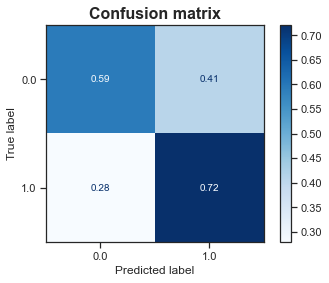

In [128]:
evaluate_model(pipe_line_smote, X_test, y_test, threshold_f3)

Accuracy score : 0.602627
f3_score : 0.516562 

Mean evalation score : 0.559595


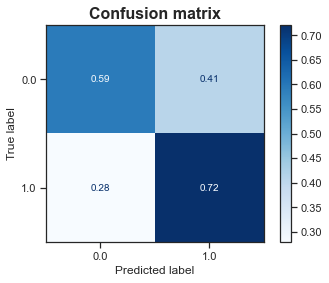

In [116]:
evaluate_model(pipe_line_smote, X_test, y_test, threshold_f3)

Accuracy score : 0.627341
f3_score : 0.472210 

Mean evalation score : 0.549776


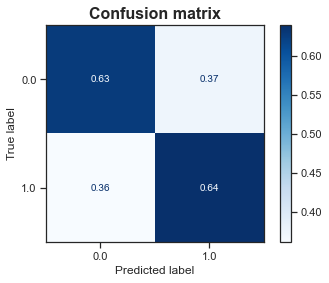

In [89]:
evaluate_model(pipe_line_smote, X_test, y_test, threshold_f3)

### Optimisation & Evaluation

In [135]:
experiment_id = dict(mlflow.set_experiment("Stacked Models Hyperparameter Tuning"))['experiment_id']
experiment_id

2023/03/13 19:28:30 INFO mlflow.tracking.fluent: Experiment with name 'Stacked Models Hyperparameter Tuning' does not exist. Creating a new experiment.


'544103083895315636'

In [149]:
def stacked_models_objective(trial):
    
    logistic_params = {
        'tol' : trial.suggest_uniform('tol' , 1e-10 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-10, 1),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1'])
    }
    if logistic_params['penalty'] == 'l1':
        logistic_params['solver'] = 'saga'
    else:
        logistic_params['solver'] = 'lbfgs'

    logistic_regression = LogisticRegression(
        **logistic_params, random_state=42, n_jobs=-1
    )
    
    randomforest_params = {# Number of trees in random forest
    'n_estimators': trial.suggest_int("n_estimators", 200, 1000),
    # Maximum number of levels in tree
    'max_depth': trial.suggest_int("max_depth", 10, 110, step=10),
    # Minimum number of samples required to split a node
    'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 10),
    # Number of features to consider at every split
    #'max_features': trial.suggest_int("max_features", 10, 211),
    # Method of selecting samples for training each tree
    'bootstrap': trial.suggest_categorical("bootstrap", [True, False])
    }

    randomforest = RandomForestClassifier( 
        **randomforest_params, n_jobs=-1, random_state=42
    )
    
    estimators = [('logisticregression', logistic_regression)]
    
    classifier = StackingClassifier(
        estimators=estimators,
        n_jobs=-1,
        final_estimator=randomforest,
        stack_method='predict_proba',
        cv=cv,
        passthrough=True
    )
    
    stacked_smote = Pipeline([('smote', smote), ('model', classifier)])
    
    scores = cross_val_score(
        stacked_smote, X_train, y_train, cv=cv, scoring=custom_score, n_jobs=-1
                             
    )
    
    params = {**logistic_params, **randomforest_params}
    mlflow_hyperparameter_tuning(experiment_id, params, scores)
    
    return scores.mean()

stacked_best_params = udf.tune(stacked_models_objective, 100)

[I 2023-03-13 21:09:35,327] A new study created in memory with name: Hyperparameters optimization
[I 2023-03-13 21:21:59,434] Trial 0 finished with value: 0.454734718858621 and parameters: {'tol': 0.0006725881035584207, 'C': 0.3987991138958647, 'penalty': 'l1', 'n_estimators': 993, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 0 with value: 0.454734718858621.
[I 2023-03-13 21:26:33,001] Trial 1 finished with value: 0.4561456035261129 and parameters: {'tol': 0.00046616942762632487, 'C': 2.2799099795108338e-10, 'penalty': 'l1', 'n_estimators': 362, 'max_depth': 100, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 0.4561456035261129.
/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kone/opt/anaconda3/envs/oc_project_env/lib/p

[I 2023-03-13 22:11:05,584] Trial 9 finished with value: 0.3966320576980161 and parameters: {'tol': 0.0008495847734699787, 'C': 0.0006440038025568012, 'penalty': 'l1', 'n_estimators': 973, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 5 with value: 0.5188447704625043.
[I 2023-03-13 22:17:31,729] Trial 10 finished with value: 0.49757764397819226 and parameters: {'tol': 2.63444246011602e-06, 'C': 3.708879088943625e-06, 'penalty': 'l2', 'n_estimators': 544, 'max_depth': 70, 'min_samples_split': 7, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 5 with value: 0.5188447704625043.
[I 2023-03-13 22:22:56,574] Trial 11 finished with value: 0.5181512401396535 and parameters: {'tol': 0.0002315538176706145, 'C': 1.616877296302631e-05, 'penalty': 'l2', 'n_estimators': 735, 'max_depth': 70, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 5 with value: 0.5188447704625043.
[I 2023-03-13 22:28:42,770] Trial

[I 2023-03-13 22:55:02,020] Trial 18 finished with value: 0.45762937701367135 and parameters: {'tol': 0.00034468131560502476, 'C': 0.2888951406493446, 'penalty': 'l2', 'n_estimators': 637, 'max_depth': 80, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 13 with value: 0.5213053199150594.
[I 2023-03-13 22:57:25,417] Trial 19 finished with value: 0.5161119780243946 and parameters: {'tol': 0.00013759414540686767, 'C': 9.810196472179545e-07, 'penalty': 'l2', 'n_estimators': 304, 'max_depth': 80, 'min_samples_split': 6, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 13 with value: 0.5213053199150594.
[I 2023-03-13 23:01:24,919] Trial 20 finished with value: 0.5118895174001783 and parameters: {'tol': 0.0002732473156546263, 'C': 0.0002304229039451588, 'penalty': 'l2', 'n_estimators': 517, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 13 with value: 0.5213053199150594.
/Users/kone/opt/anaconda3/env

[I 2023-03-13 23:14:34,354] Trial 23 finished with value: 0.4910924100314653 and parameters: {'tol': 0.000145236079433311, 'C': 0.003058303137840073, 'penalty': 'l2', 'n_estimators': 618, 'max_depth': 80, 'min_samples_split': 8, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 13 with value: 0.5213053199150594.
[I 2023-03-13 23:19:27,428] Trial 24 finished with value: 0.5202337097628129 and parameters: {'tol': 0.0002667460591128999, 'C': 0.00015231296616623587, 'penalty': 'l2', 'n_estimators': 654, 'max_depth': 60, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 13 with value: 0.5213053199150594.
[I 2023-03-13 23:24:22,123] Trial 25 finished with value: 0.5187512670745268 and parameters: {'tol': 0.0002867517624962154, 'C': 0.00010589849572292074, 'penalty': 'l2', 'n_estimators': 649, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 13 with value: 0.5213053199150594.
/Users/kone/opt/anaconda3/envs

/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

[I 2023-03-13 23:54:32,202] Trial 29 finished with value: 0.4532619168627766 and parameters: {'tol': 0.00034511059352829686, 'C': 0.010018387383938673, 'penalty': 'l1', 'n_estimators': 792, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 13 with value: 0.5213053199150594.
[I 2023-03-13 23:57:45,870] Trial 30 finished with value: 0.5177525631552636 and parameters: {'tol': 7.650569850006862e-05, 'C': 1.4245538990334303e-05, 'penalty': 'l2', 'n_estimators': 410, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 13 with value: 0.5213053199150594.
[I 2023-03-14 00:02:02,499] Trial 31 finished with value: 0.5161883063347172 and parameters: {'tol': 0.0001841310151998787, 'C': 0.0002469011786446593, 'penalty': 'l2', 'n_estimators': 552, 'max_depth': 70, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 13 with value: 0.5213053199150594.
/Users/kone/opt/anaconda3/en

[I 2023-03-14 00:27:03,276] Trial 36 finished with value: 0.5033021950223129 and parameters: {'tol': 0.00018340445563839065, 'C': 1.642795316562942e-05, 'penalty': 'l2', 'n_estimators': 784, 'max_depth': 60, 'min_samples_split': 5, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 00:32:49,441] Trial 37 finished with value: 0.5069535992462878 and parameters: {'tol': 0.00048419513352969266, 'C': 7.110292685346408e-05, 'penalty': 'l2', 'n_estimators': 679, 'max_depth': 100, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 00:37:37,011] Trial 38 finished with value: 0.4921362670571515 and parameters: {'tol': 0.00039608010160475807, 'C': 0.003964965727406863, 'penalty': 'l1', 'n_estimators': 300, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
/Users/kone/opt/anaconda3/

[I 2023-03-14 00:43:35,661] Trial 39 finished with value: 0.5124927782775306 and parameters: {'tol': 5.629925939819026e-05, 'C': 1.0921430932750344e-06, 'penalty': 'l2', 'n_estimators': 838, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 00:48:36,528] Trial 40 finished with value: 0.462591641937114 and parameters: {'tol': 0.0001321126294988545, 'C': 0.05455778911874631, 'penalty': 'l2', 'n_estimators': 586, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 00:52:26,820] Trial 41 finished with value: 0.5216476544788312 and parameters: {'tol': 0.00014194238738520783, 'C': 0.00010651344669799637, 'penalty': 'l2', 'n_estimators': 510, 'max_depth': 80, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
/Users/kone/opt/anaconda3/env

[I 2023-03-14 01:16:31,684] Trial 47 finished with value: 0.5079324136674371 and parameters: {'tol': 9.340148825995637e-05, 'C': 3.5040551143381445e-05, 'penalty': 'l1', 'n_estimators': 596, 'max_depth': 80, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 01:21:30,828] Trial 48 finished with value: 0.4673365869470838 and parameters: {'tol': 3.1702360986203565e-05, 'C': 0.0020107260802443936, 'penalty': 'l2', 'n_estimators': 402, 'max_depth': 70, 'min_samples_split': 2, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 32 with value: 0.5217178797984975.
/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter 

[I 2023-03-14 01:27:40,245] Trial 49 finished with value: 0.4882589479503244 and parameters: {'tol': 0.00015984872859983062, 'C': 0.00046633473050138974, 'penalty': 'l2', 'n_estimators': 741, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 01:30:24,673] Trial 50 finished with value: 0.5214904263462838 and parameters: {'tol': 0.00021418426190477637, 'C': 7.754320057591223e-05, 'penalty': 'l2', 'n_estimators': 313, 'max_depth': 70, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 01:33:10,278] Trial 51 finished with value: 0.5213944736356522 and parameters: {'tol': 0.00021336825458661925, 'C': 7.558297377284024e-05, 'penalty': 'l2', 'n_estimators': 340, 'max_depth': 70, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 32 with value: 0.5217178797984975.
[I 2023-03-14 01:35:26,624]

[I 2023-03-14 02:21:52,222] Trial 69 finished with value: 0.49776448929167394 and parameters: {'tol': 0.0002845972900397936, 'C': 0.0010187421613309987, 'penalty': 'l2', 'n_estimators': 484, 'max_depth': 60, 'min_samples_split': 10, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 53 with value: 0.5236448800212556.
/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarnin

[I 2023-03-14 03:12:22,008] Trial 84 finished with value: 0.5027519641982131 and parameters: {'tol': 0.0001306880754066782, 'C': 0.0006991729498056883, 'penalty': 'l2', 'n_estimators': 276, 'max_depth': 70, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 53 with value: 0.5236448800212556.
[I 2023-03-14 03:14:01,391] Trial 85 finished with value: 0.5167468252882479 and parameters: {'tol': 6.977639664743653e-05, 'C': 3.214526096853402e-05, 'penalty': 'l2', 'n_estimators': 203, 'max_depth': 60, 'min_samples_split': 5, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 53 with value: 0.5236448800212556.
[I 2023-03-14 03:17:14,725] Trial 86 finished with value: 0.5146356750932366 and parameters: {'tol': 0.0001137286380565032, 'C': 0.0001967689016641687, 'penalty': 'l2', 'n_estimators': 412, 'max_depth': 70, 'min_samples_split': 4, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 53 with value: 0.5236448800212556.
[I 2023-03-14 03:24:02,257] Tri

Best score: 0.5236448800212556

Optimized parameters: {'tol': 0.0002168333834926689, 'C': 0.00012720838557589821, 'penalty': 'l2', 'n_estimators': 311, 'max_depth': 80, 'min_samples_split': 9, 'min_samples_leaf': 8, 'bootstrap': True}



In [150]:
stacked_best_params

{'tol': 0.0002168333834926689,
 'C': 0.00012720838557589821,
 'penalty': 'l2',
 'n_estimators': 311,
 'max_depth': 80,
 'min_samples_split': 9,
 'min_samples_leaf': 8,
 'bootstrap': True}

In [151]:
logisticregression_params = {
    'tol': 0.0002168333834926689,
     'C': 0.00012720838557589821,
     'penalty': 'l2'
}

logisticregression = LogisticRegression(random_state=42, n_jobs=-1, **logisticregression_params)

randomforest_params = {
     'n_estimators': 311,
     'max_depth': 80,
     'min_samples_split': 9,
     'min_samples_leaf': 8,
     'bootstrap': True
}
randomforest = RandomForestClassifier(random_state=42, n_jobs=-1, **randomforest_params)

estimators = [
    ('logisticregression', logisticregression),
]

classifier = StackingClassifier(
    estimators=estimators,
    n_jobs=-1,
    final_estimator=randomforest,
    stack_method='predict_proba',
    cv=cv,
    passthrough=True
)

In [152]:
pipe_line_smote = Pipeline([('smote', smote), ('model', classifier)])
pipe_line_smote

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1001, shuffle=True),
                                    estimators=[('logisticregression',
                                                 LogisticRegression(C=0.00012720838557589821,
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    tol=0.0002168333834926689))],
                                    final_estimator=RandomForestClassifier(max_depth=80,
                                                                           min_samples_leaf=8,
                                                                           min_samples_split=9,
                                                                           n_estimators=311,
                                                                           n_jobs=-1,
                                                                           random_state=42),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='predict_proba'))])

In [153]:
pipe_line_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1001, shuffle=True),
                                    estimators=[('logisticregression',
                                                 LogisticRegression(C=0.00012720838557589821,
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    tol=0.0002168333834926689))],
                                    final_estimator=RandomForestClassifier(max_depth=80,
                                                                           min_samples_leaf=8,
                                                                           min_samples_split=9,
                                                                           n_estimators=311,
                                                                           n_jobs=-1,
                                                                           random_state=42),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='predict_proba'))])

In [154]:
y_pred_proba = pipe_line_smote.predict_proba(X_test)[:,1]
threshold_f3 = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.2, le f3_score est : 0.528 et le mean score est : 0.581


Accuracy score : 0.634105
f3_score : 0.527867 

Mean evalation score : 0.580986


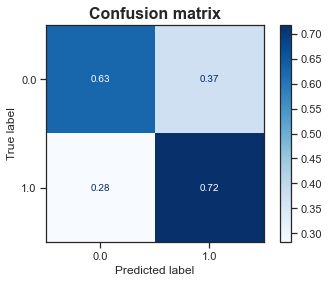

In [155]:
evaluate_model(pipe_line_smote, X_test, y_test, threshold_f3)

## Test de données

In [60]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

randomforest_params = {
    'n_estimators': 882, 
    'max_depth': 20, 
    'min_samples_split': 6,
    'min_samples_leaf': 10, 
    'bootstrap': True
    }

forest = RandomForestClassifier(**randomforest_params)
forest_smote = Pipeline([('smote', smote), ('model', forest)])
#models["RandomForestClassifier"] = forest_smote

#Staking models logistic_regression + RandomForest
#LogisticRegression
from sklearn.linear_model import LogisticRegression

logistic_params = {
    'tol': 0.0002329433780056682, 
    'C': 6.681553108313681e-08, 
    'penalty': 'l2',
    'random_state': 42,
    'n_jobs': -1
    }
logistic_regression = LogisticRegression(**logistic_params)

estimators_0 = [
    ('LogisticRegression', logistic_regression)
]
classifier_0 = StackingClassifier(
    estimators=estimators_0,
    n_jobs=-1,
    final_estimator=forest,
    stack_method='predict_proba',
    cv=cv,
    passthrough=True
)

clf_smote = Pipeline([('smote', smote), ('model', classifier_0)])

scoring = {
    'f3_score': make_scorer(udf.f3_score, needs_proba=True),
    'accuracy': make_scorer(udf.custom_accuracy_score, needs_proba=True),
    'recall_score': make_scorer(udf.custom_recall_score, needs_proba=True),
    'preciion_score': make_scorer(udf.custom_precision_score, needs_proba=True)
}

In [79]:
clf_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=17, random_state=1001)),
                ('model',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x7FE8D8A34440, shuffle=False),
                                    estimators=[('LogisticRegression',
                                                 LogisticRegression(C=6.681553108313681e-08,
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    tol=0.0002329433780056682))],
                                    final_estimator=RandomForestClassifier(max_depth=20,
                                                                           min_samples_leaf=10,
                                                                           min_samples_split=6,
                                                                           n_estimators=882),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='predict_proba'))])

In [95]:
y_pred_proba = clf_smote.predict_proba(X_test)[:,1]
threshold_f3 = custom_metric(y_test, y_pred_proba, return_proba=True)[1]


Pour le seuil 0.2, le f3_score est : 0.532 et le mean score est : 0.587


Accuracy score : 0.641349
f3_score : 0.532339 

Mean evalation score : 0.586844


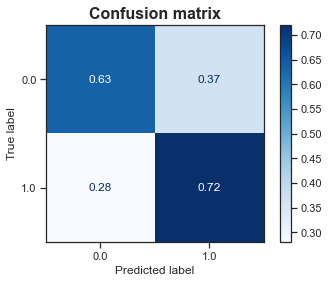

In [98]:
evaluate_model(clf_smote, X_test, y_test, threshold_f3)

In [ ]:
'/Users/kone/Desktop/Oc_Formation/Projets/Projet7/openclassrooms_projects7/model_and_data/test_df.csv'

In [99]:
test_df = pd.read_csv(Path(PROJECT_ROOT + '/model_and_data/test_df.csv'), index_col=[0])
#data.set_index('SK_ID_CURR', inplace=True)
test_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,0,0,-0.577530,-0.075102,-0.451695,-0.146668,-0.734183,-0.161753,-0.052189,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100005,0,0,0,-0.577530,-0.934825,-0.671813,1.079459,-0.464475,-1.089349,-1.173430,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100013,0,1,0,-0.577530,0.159595,2.943833,-0.127871,-0.916815,-1.084148,0.797684,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100028,1,0,0,2.192118,2.424820,1.511669,0.399884,0.472288,0.038503,0.847643,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0
100038,0,1,1,0.807294,0.065770,0.342157,-0.783588,0.686772,-0.102803,0.279926,...,0.0,0.0,0.0,0.0,-0.045826,0.0,0.0,0.0,0.0,0.0


In [100]:
y_pred_proba = clf_smote.predict_proba(test_df)[:,1]

In [102]:
label_pred_threshold = np.where(y_pred_proba >= 0.2, 1, 0)

In [103]:
i = 0
for proba, label in zip(y_pred_proba, label_pred_threshold):
    i += 1
    print(proba, label)
    
    if i == 10:
        break

0.1118314048476198 0
0.5850502145937753 1
0.09357003943795922 0
0.2282706785301131 1
0.33975209730633915 1
0.1956492622838609 0
0.03879165884658396 0
0.15526735849897955 0
0.05757501125705644 0
0.24384417314380577 1


In [105]:
list(label_pred_threshold).count(1)

18867

In [106]:
list(label_pred_threshold).count(0)

29877

In [107]:
len(list(label_pred_threshold))

48744

In [109]:
1 - 0.2

0.8

In [114]:
1 - 0.2282706785301131

0.7717293214698869

In [113]:
1 - 0.15526735849897955

0.8447326415010205

In [115]:
import pickle
pickle.dump(clf_smote, open(Path(PROJECT_ROOT + '/model_and_data/model.pkl'), 'wb'))